                         Assignment-2 CNN
                         sseetham@kent.edu

---



### Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ananthkumar19","key":"6b8fa06ec816c8f961220ef0b50eaf5b"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:03<00:00, 176MB/s]
100% 812M/812M [00:03<00:00, 231MB/s]


In [42]:
!unzip -qq dogs-vs-cats.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [69]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=1000, end_index=10000)
make_subset("validation", start_index=500, end_index=1000)
make_subset("test", start_index=0, end_index=500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [70]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [71]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

**Configuring the model for training**

In [72]:
model.compile(loss="binary_crossentropy",
              optimizer="ADAM",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [73]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 18000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [74]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [75]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [76]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [77]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [78]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [80]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
563/563 [==============================] - 62s 109ms/step - loss: 0.0764 - accuracy: 0.9719 - val_loss: 0.4569 - val_accuracy: 0.8600
Epoch 2/30
563/563 [==============================] - 59s 105ms/step - loss: 0.0561 - accuracy: 0.9787 - val_loss: 0.4907 - val_accuracy: 0.8650
Epoch 3/30
563/563 [==============================] - 60s 106ms/step - loss: 0.0555 - accuracy: 0.9802 - val_loss: 0.5128 - val_accuracy: 0.8550
Epoch 4/30
563/563 [==============================] - 59s 104ms/step - loss: 0.0518 - accuracy: 0.9814 - val_loss: 0.6800 - val_accuracy: 0.8350
Epoch 5/30
563/563 [==============================] - 59s 105ms/step - loss: 0.0447 - accuracy: 0.9836 - val_loss: 0.5569 - val_accuracy: 0.8640
Epoch 6/30
563/563 [==============================] - 59s 105ms/step - loss: 0.0391 - accuracy: 0.9856 - val_loss: 0.6450 - val_accuracy: 0.8590
Epoch 7/30
563/563 [==============================] - 59s 105ms/step - loss: 0.0362 - accuracy: 0.9871 - val_loss: 0.6419 - val_ac

**Displaying curves of loss and accuracy during training**

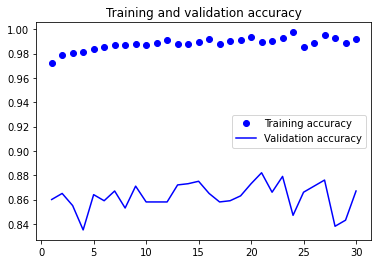

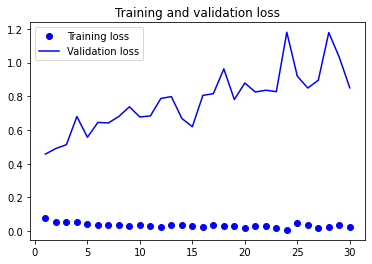

In [83]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [84]:
test_model = keras.models.load_model("convnet_from_scratch_2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.4258 - accuracy: 0.8720
Test accuracy: 0.872


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [85]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

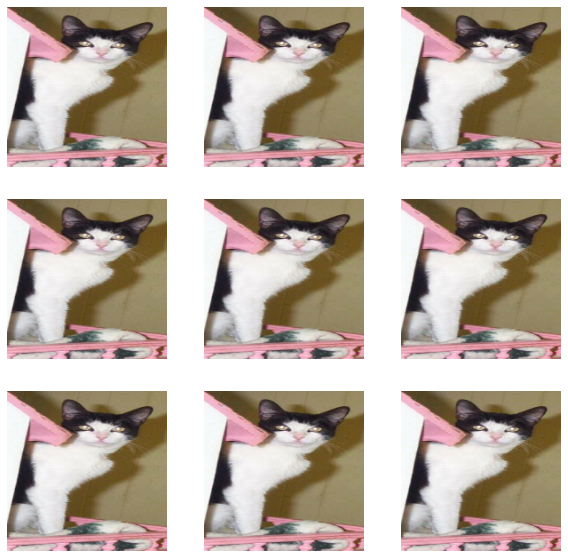

In [86]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [87]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="ADAM",
              metrics=["accuracy"])

**Training the regularized convnet**

In [88]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
563/563 [==============================] - 66s 112ms/step - loss: 0.6897 - accuracy: 0.5266 - val_loss: 0.6815 - val_accuracy: 0.5350
Epoch 2/30
563/563 [==============================] - 63s 112ms/step - loss: 0.6836 - accuracy: 0.5534 - val_loss: 0.6832 - val_accuracy: 0.5630
Epoch 3/30
563/563 [==============================] - 63s 111ms/step - loss: 0.6702 - accuracy: 0.5864 - val_loss: 0.6324 - val_accuracy: 0.6460
Epoch 4/30
563/563 [==============================] - 63s 112ms/step - loss: 0.6211 - accuracy: 0.6577 - val_loss: 0.5643 - val_accuracy: 0.7110
Epoch 5/30
563/563 [==============================] - 63s 111ms/step - loss: 0.5630 - accuracy: 0.7117 - val_loss: 0.5046 - val_accuracy: 0.7580
Epoch 6/30
563/563 [==============================] - 63s 111ms/step - loss: 0.5101 - accuracy: 0.7497 - val_loss: 0.4635 - val_accuracy: 0.7680
Epoch 7/30
563/563 [==============================] - 63s 111ms/step - loss: 0.4744 - accuracy: 0.7709 - val_loss: 0.4160 - val_ac

**Evaluating the model on the test set**

In [96]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 99ms/step - loss: 0.2065 - accuracy: 0.9140
Test accuracy: 0.914


**Instantiating the VGG16 convolutional base**

In [90]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [91]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Fine-tuning a pretrained model

In [92]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Freezing all layers until the fourth from the last**

In [93]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [97]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
563/563 [==============================] - 67s 115ms/step - loss: 0.1892 - accuracy: 0.9201 - val_loss: 0.1920 - val_accuracy: 0.9080
Epoch 2/30
563/563 [==============================] - 65s 114ms/step - loss: 0.1829 - accuracy: 0.9238 - val_loss: 0.1901 - val_accuracy: 0.9080
Epoch 3/30
563/563 [==============================] - 65s 115ms/step - loss: 0.1902 - accuracy: 0.9199 - val_loss: 0.1914 - val_accuracy: 0.9080
Epoch 4/30
563/563 [==============================] - 65s 114ms/step - loss: 0.1825 - accuracy: 0.9257 - val_loss: 0.1912 - val_accuracy: 0.9090
Epoch 5/30
563/563 [==============================] - 65s 114ms/step - loss: 0.1850 - accuracy: 0.9207 - val_loss: 0.1901 - val_accuracy: 0.9110
Epoch 6/30
563/563 [==============================] - 65s 114ms/step - loss: 0.1885 - accuracy: 0.9213 - val_loss: 0.1895 - val_accuracy: 0.9090
Epoch 7/30
563/563 [==============================] - 65s 114ms/step - loss: 0.1828 - accuracy: 0.9236 - val_loss: 0.1905 - val_ac

In [98]:
model = keras.models.load_model("fine_tuning_1.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.1656 - accuracy: 0.9380
Test accuracy: 0.938


## Summary

1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation 
sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce 
overfitting and improve performance in developing a network that you train from scratch. What 
performance did you achieve?  

Answer: 

**Unregularized:**

In unregularized model the test accuracy is around: 75.2 with ADAM optimizer.

The model seems to be overfitting after certain epoch which might not generalized with the new data.

**Regularized with drop out and augmentation:**

In this model there is better performance improvement with accruracy of 79.2

In both the models 1000 sample are teken for training 

By fine tuning the model the test accuracy is at 82.0 and loss at 41.31 

The training sample of 1000 does not seems to be sufficeient enough for the model to reduce the loss and increase the accuracy.

.

-------------------------------

2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What 
performance did you achieve?  

For this model I have increased the samle size to 5000. 

**For unregularized model** It is observed that the model maybe overfitting after certain epoch.

Test accuracy: 0.833 which is in contrast is an improvement comapred to the model with only 1000 training sample. 

**For regularized model:**


for regularized model it is observed that the loss: 0.2726 - accuracy: 0.8880

In contrast to the unregularized model regularized model seems to have a bit higher accuracy. 

Incomparision to the previous model the accuracy seems to be improved while the loss is slightly reduced.


-------------------------------

3. Now change your training sample so that you achieve better performance than those from Steps 
1 and 2. This sample size may be larger, or smaller than those in the previous steps. The 
objective is to find the ideal training sample size to get best prediction results?

Answer: 

In this model the training size is 10,000 

for unregularized model it is observed that the loss: 0.4258 - accuracy: 0.8720

For regularized model it is observed that the loss: 0.2065 - accuracy: 0.9140

In comparision this model is better than the previous model.

-------------------------------

4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 
for the pretrained network may be the same or different from those using the network where 
you trained from scratch. Again, use any and all optimization techniques to get best 
performance.

**For training Sample Size of 1000 with regularization **
After fine turing the model, it is observed that the loss: 0.2652 - accuracy: 0.8900 which is slightly better than untuned regularized model

**For training Sample Size of 5000 with regularization **
After fine turing the model, it is observed that the loss: 0.2429 - accuracy: 0.8976 which is slightly better than untuned regularized model. 

**For training Sample Size of 10000 with regularization **

After fine turing the model, it is observed that the loss: 0.1656 - accuracy: 0.9380. which is so far the best model than untuned regularized model. Time and space complexity 
-------------------------------

**Recommendations:**

From the different training sample size, every model did perform well, but the fine tuned model with higher training sample with dropout and data augmentation is highly accurate with less loss rate. 

However, there is a drawback for higher training sample, for model with 5000 training sample each epoch took around 59s and for the model with 10000 it took almost 63s. There is an issue with time and space complexity with higher training sample models. If a proper infrastructure is provided then these issues can be handled. 

But the best efficient model is the fine tune with higher training sample (5000,10000) using the pretained network while test and validation remains of the same size of 500.








-------------------------------

